In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import skew, kurtosis
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")
import config
from pathlib import Path

import load_commodities_data as lcd
import data_preprocessing as dp

In [2]:
DATA_DIR = Path(config.DATA_DIR)
data_dir = DATA_DIR

file_name = "commodities_data_2024.csv"

Load and preprocess data

In [3]:
df = lcd.load_data(data_dir, file_name)
df = dp.preprocess_data(df)

### Understanding the data

Total number of commodities - 26

### Sector

The below plot gives us an understanding of the commodities by sectors. Most commodities are in agriculture sector.

In [8]:
commodity_sector_mapping = {
    'Cocoa': 'Agriculture',
    'Corn': 'Agriculture',
    'Cotton': 'Agriculture',
    'Live cattle': 'Livestock',
    'Oats': 'Agriculture',
    'Orange juice': 'Agriculture',
    'Soybean meal': 'Agriculture',
    'Soybeans': 'Agriculture',
    'Wheat': 'Agriculture',
    'Feeder cattle': 'Livestock',
    'Coffee': 'Agriculture',
    'Gold': 'Metals',
    'Silver': 'Metals',
    'Canola': 'Agriculture',
    'Crude Oil': 'Energy',
    'Heating Oil': 'Energy',
    'Lean hogs': 'Livestock',
    'Palladium': 'Metals',
    'Platinum': 'Metals',
    'Lumber': 'Agriculture',
    'Unleaded gas': 'Energy',
    'Copper': 'Metals',
    'Rough rice': 'Agriculture',
    'Natural gas': 'Energy',
    'Aluminium': 'Metals',
    'Gasoline': 'Energy',
}

df['Sector'] = df['Commodity'].map(commodity_sector_mapping)

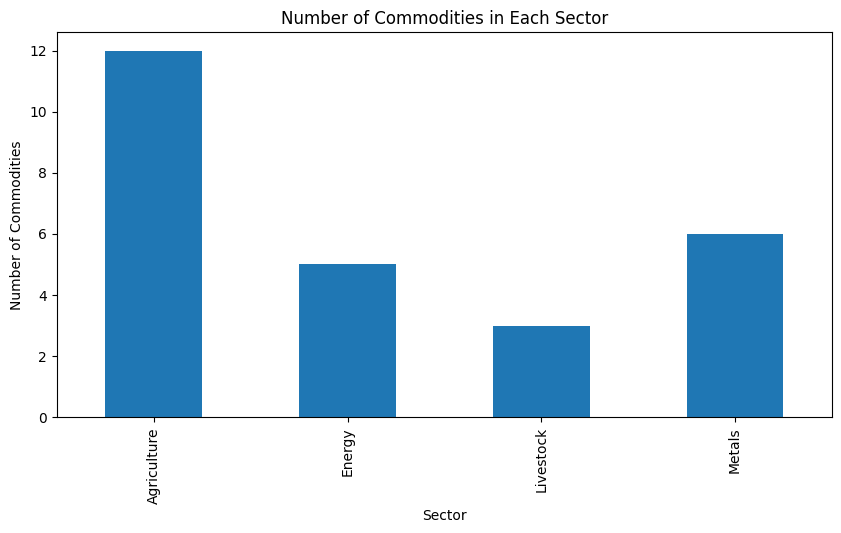

In [9]:
df.groupby('Sector')['Commodity'].nunique().plot(kind='bar', figsize=(10, 5), title='Number of Commodities in Each Sector')
plt.ylabel('Number of Commodities')
plt.xlabel('Sector')
plt.show()

### Data availability

The below grid gives a representation of data availability for each commodity across different number of contracts

Blue: Available <br>
Red: Not available

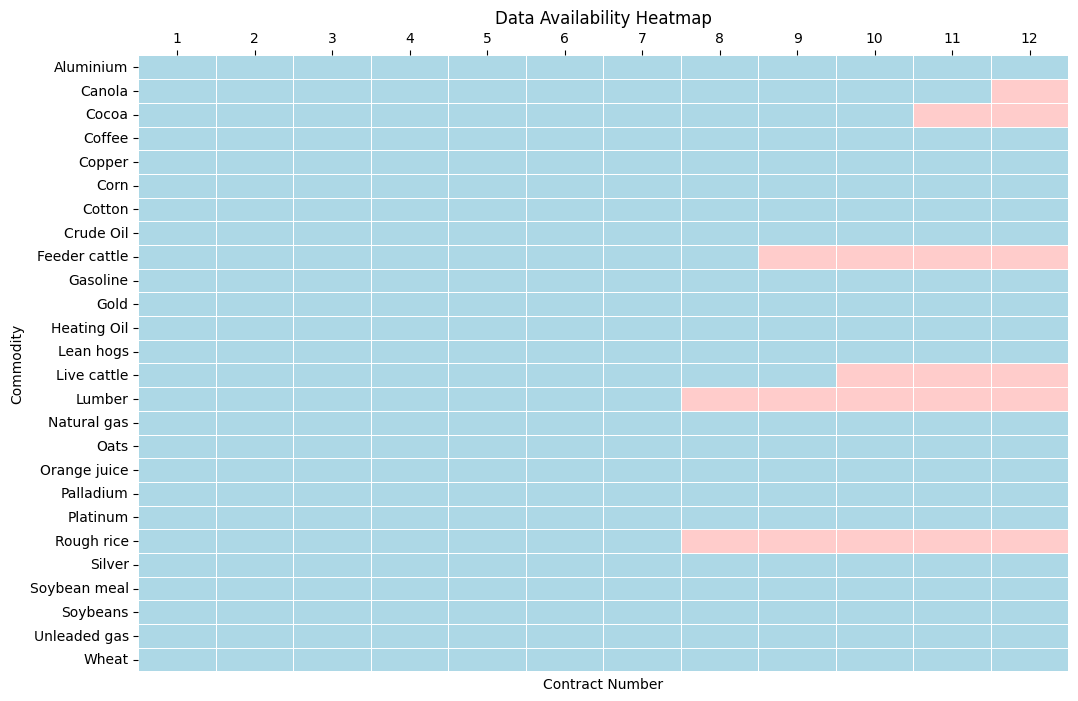

In [93]:
pivot_df = df.pivot_table(index='Commodity', columns='Contract', values='ClosePrice', aggfunc='count')

# Convert the counts to a binary format (1 for available, 0 for not available)
availability_df = pivot_df.notnull().astype(int)
cmap = ListedColormap(['#FFCCCB', '#ADD8E6'])
plt.figure(figsize=(12, 8))
sns.heatmap(availability_df, cmap=cmap, cbar=False, linewidths=.5, annot=False)

# Move the x-axis labels to the top
ax = plt.gca()
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

plt.title('Data Availability Heatmap')
plt.xlabel('Contract Number')
plt.ylabel('Commodity')

plt.show()

### Maximum contract number-

The paper includes futures contracts of maturities up to 12 months for a cross section of many commodities.

- The below plot gives us an insight on the maximum contract number available from the Bloomberg data download. As can be seen, most of the commodities have contracts going upto 12th to expire
- Lesser liquid (in terms of volume traded) commodities have lower maximum contract number such as Lumber, rough rice, Feeder Cattle

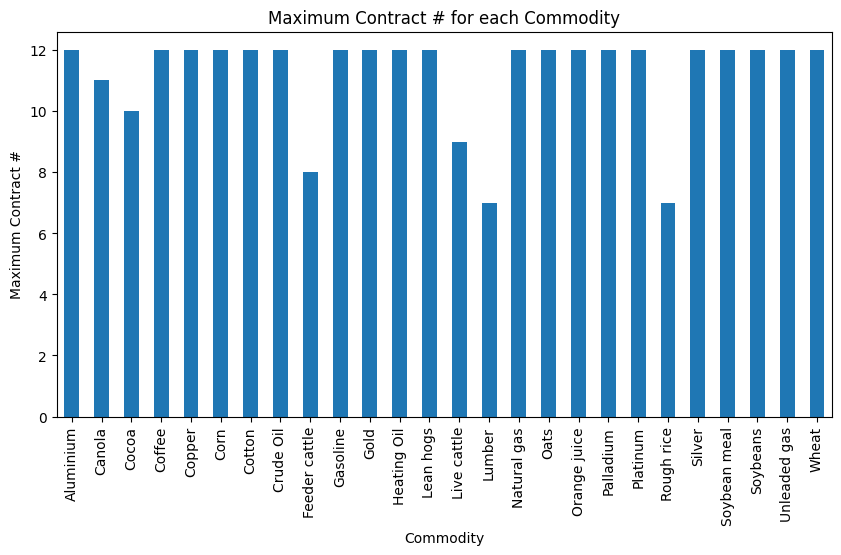

In [10]:
df.groupby('Commodity')['Contract'].max().plot(kind='bar', figsize=(10, 5), title = 'Maximum Contract # for each Commodity')
plt.ylabel('Maximum Contract #')
plt.show()

The below plots give us a sense of data quality in terms of 1) across time and 2) maximum contract or number of contracts available across time

Top level insights:
- Overall the data quality looks good for the purpose of this project
- the starting line of each plot tells us the first available data point. This shows each commodity has different start date.
- the maximum contract number stabilises with time. This is expected as liquidity and data quality has improved over time.
- Lumber, Unleaded gas : these commodities seem to have stopped trading or may have undergone some contract changes as we can see the curves do not continue till the end

Note: for basis calculation, we need atleast two contracts at each time stamp.

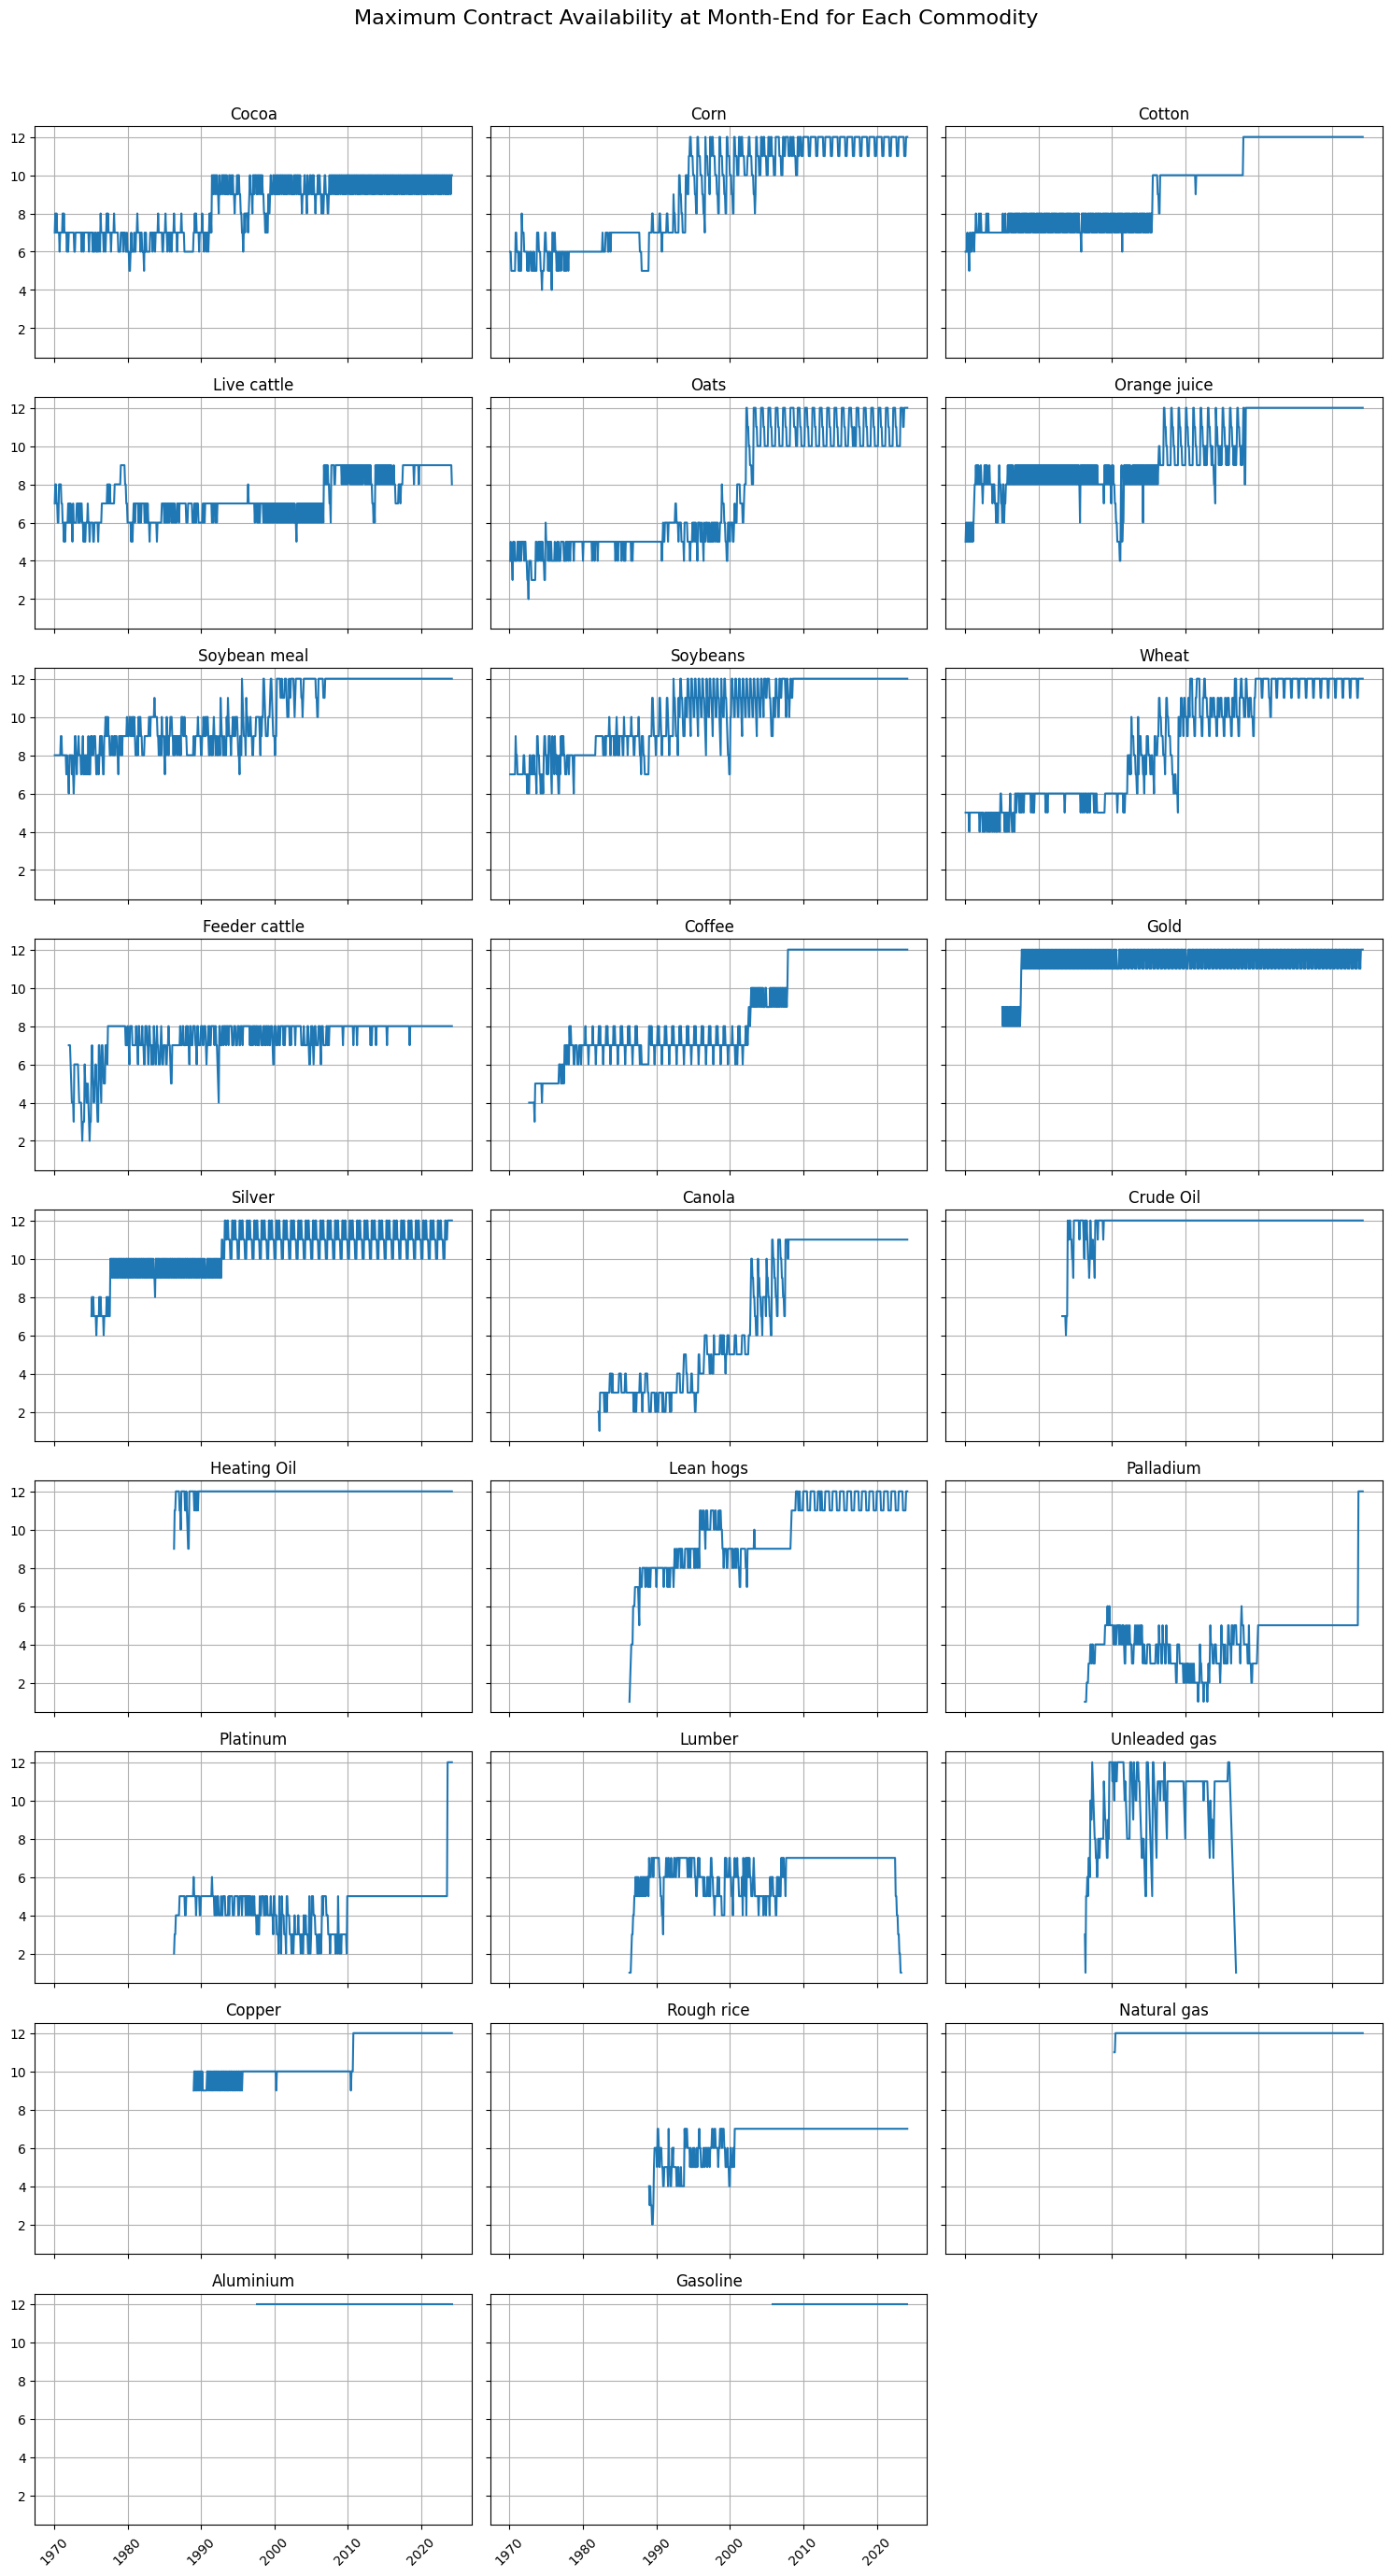

In [11]:
sample_df_grouped = df.groupby('Commodity').resample('M').max()
sample_df_grouped = sample_df_grouped.drop(columns='Commodity').reset_index()

commodities = df['Commodity'].unique()
num_commodities = df['Commodity'].nunique()

cols = 3
rows = -(-num_commodities // cols)  # Ceiling division to ensure enough rows

fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows), sharex=True, sharey=True)
fig.suptitle('Maximum Contract Availability at Month-End for Each Commodity', fontsize=16, y=1.02)
axs = axs.flatten()

# Plotting each commodity's max contract availability at month-end
for idx, commodity in enumerate(commodities):
    if idx >= len(axs):
        break
    ax = axs[idx]
    data = sample_df_grouped[sample_df_grouped['Commodity'] == commodity]
    ax.plot(data['Date'], data['Contract'], linestyle='-')
    ax.set_title(commodity)
    ax.tick_params(axis='x', rotation=45)  # Rotating x-ticks for clarity
    ax.grid(True)

for ax in axs[idx + 1:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### Deep dive into replication table variables 

Given we have 26 commodities to look at, for the purpose of illustration we have only looked at one commodity - Aluminium

Date range: This analysis for entire data availability until end of Feb 2024



In [22]:
commodity_to_analyse = 'Aluminium'

In [23]:
df_select = df[df['Commodity'] == commodity_to_analyse]
unique_contracts = df_select['Contract'].unique()

### Time series plot

We can see that the time series converges close to each other with time. This can be attributed to -

- market inefficiencies
- liquidity improvements
- more sophisticated models removing the arbitrage opportunities

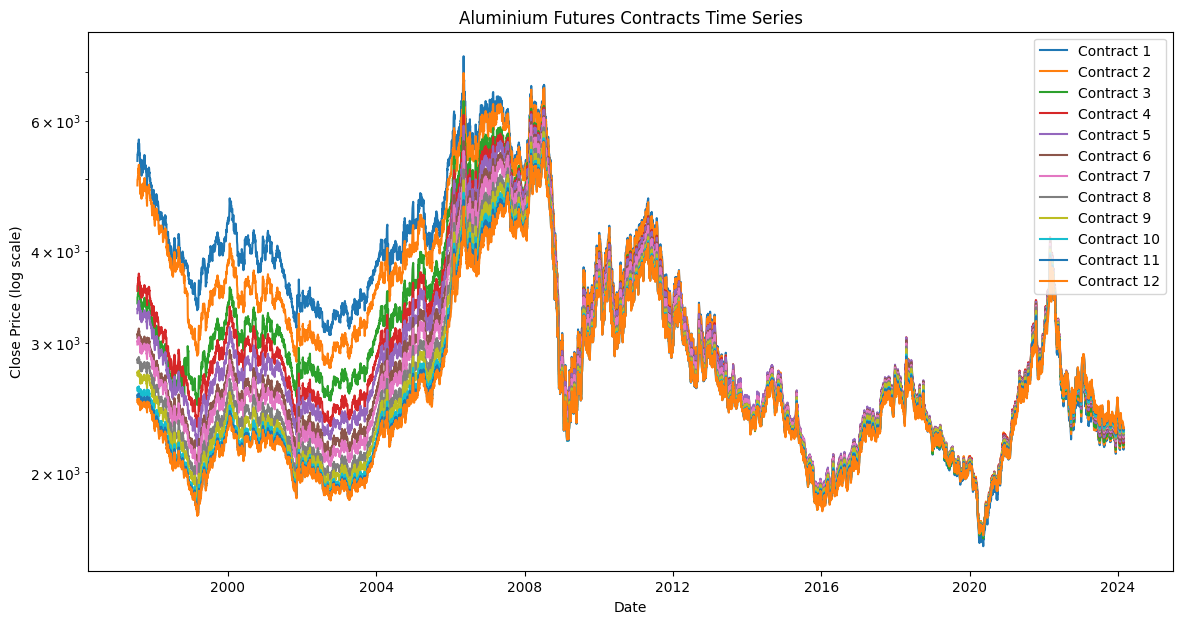

In [28]:
plt.figure(figsize=(14, 7))
for contract in unique_contracts:
    contract_data = df_select[df_select['Contract'] == contract]
    plt.plot(contract_data.index, contract_data['ClosePrice'], label=f'Contract {contract}')

plt.yscale('log')
plt.title(f'{commodity_to_analyse} Futures Contracts Time Series')
plt.xlabel('Date')
plt.ylabel('Close Price (log scale)')
plt.legend()
plt.show()


### Returns

Return distribution indicates -
- Slightly positive skew
- Negligible excess kurtosis
- Centred around 0
- Min, Max monthly returns range around the magnitude of ~15%

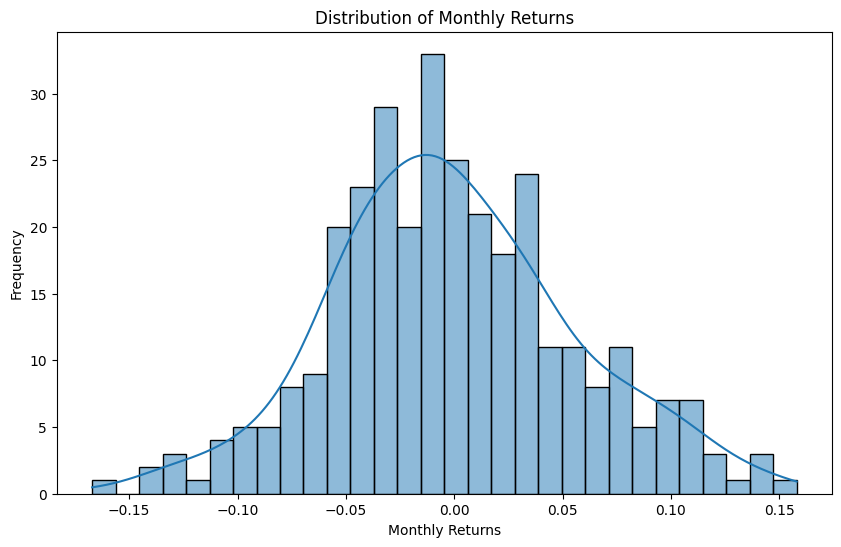

Descriptive Statistics for Monthly Returns:
count       319.000000
mean         -0.001048
std           0.056528
min          -0.167116
25%          -0.038797
50%          -0.005446
75%           0.033382
max           0.158073
skew          0.174180
kurtosis      0.096838
Name: Monthly returns, dtype: float64


In [60]:
contract_num_returns = 2

returns_df = df_select[df_select['Contract'] == contract_num_returns].resample('M').last()
returns_df['Monthly returns'] = returns_df['ClosePrice'].pct_change()
returns_df = returns_df.dropna()

# Plotting the distribution of monthly returns with a histogram
plt.figure(figsize=(10, 6))
sns.histplot(returns_df['Monthly returns'], kde=True, bins=30)
plt.title(f'Distribution of Monthly Returns')
plt.xlabel('Monthly Returns')
plt.ylabel('Frequency')

# Display the plot
plt.show()

# Calculating descriptive statistics
stats = returns_df['Monthly returns'].describe()
stats['skew'] = skew(returns_df['Monthly returns'])
stats['kurtosis'] = kurtosis(returns_df['Monthly returns'])

# Displaying descriptive statistics
print("Descriptive Statistics for Monthly Returns:")
print(stats)

### Volatility

We look at the 5 year rolling volatility (annualized). 

- rises significantly during the Global Financial Crisis
- mutes down eventually
- starts rising again after Covid Crisis and then further increases during the Russia-Ukraine war in 2022

In [74]:
rolling_window = 60

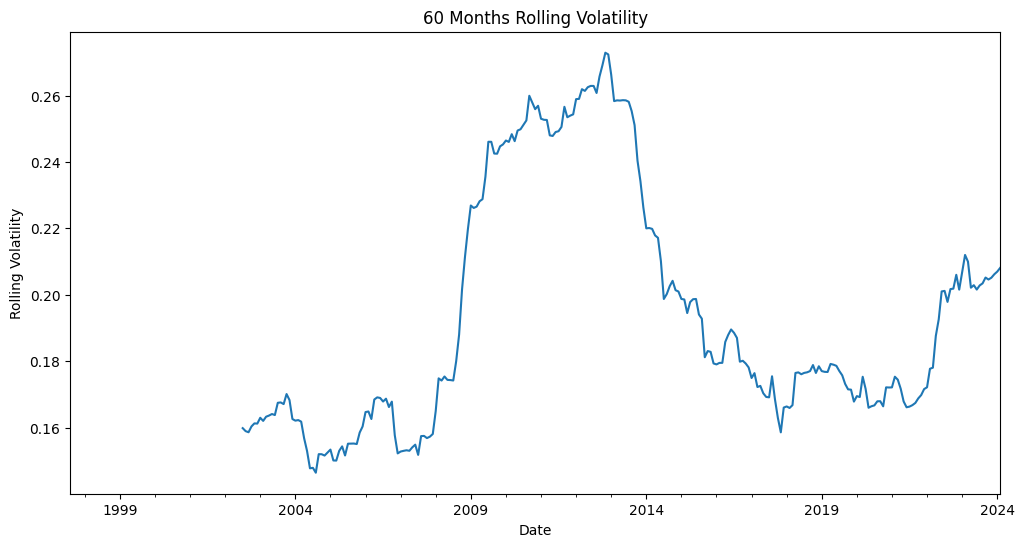

In [75]:
returns_df['Rolling Volatility'] = returns_df['Monthly returns'].rolling(window=rolling_window).std() * np.sqrt(12) # Annualized volatility

plt.figure(figsize=(12, 6))
returns_df['Rolling Volatility'].plot(title=f'{rolling_window} Months Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Rolling Volatility')
plt.show()

### Sharpe Ratio

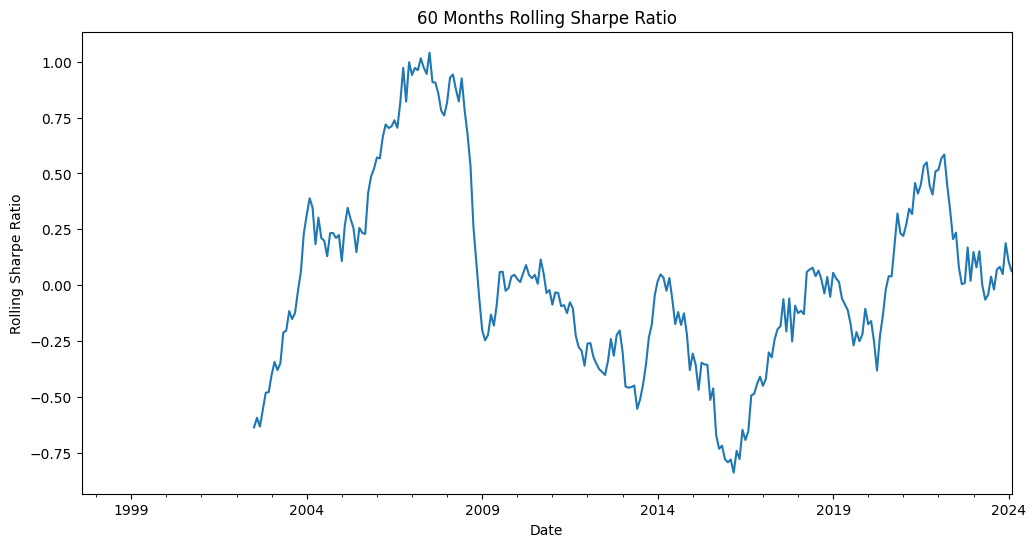

In [76]:
returns_df['Rolling Mean Returns'] = returns_df['Monthly returns'].rolling(window=rolling_window).mean()*12

returns_df['Rolling Sharpe Ratio'] = returns_df['Rolling Mean Returns'] / returns_df['Rolling Volatility']

plt.figure(figsize=(12, 6))
returns_df['Rolling Sharpe Ratio'].plot(title=f'{rolling_window} Months Rolling Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.show()

### Basis

Basis essentially measures the slope of the futures curve. It is defined as the difference between its contemporaneous spot price and futures price with some maturity. 

Empirically, because spot and futures contracts are traded on separated markets and the nearest futures price is very close to the spot price due to the no-arbitrage condition, we usually use the nearest futures price to substitute for the spot price to compute the basis. 

According to paper, it is defined as the log difference between the one-month first available futures price and the last available futures price divided by the difference in maturities.

$$
B_i,t = \frac{\log(F_{i,t,T_1}) - \log(F_{i,t,T_2})}{T_2 - T_1}
$$

The below plot gives a visual representation of how basis changes over time with respect to the underlying futures series.

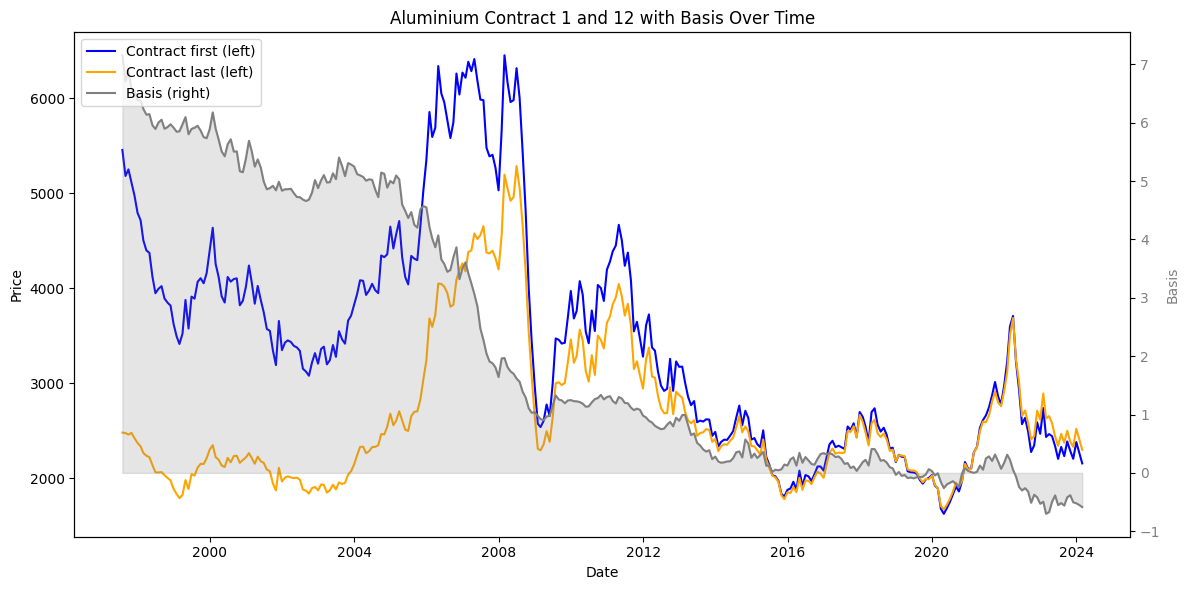

In [103]:
first_contract_num = unique_contracts[0]
last_contract_num = unique_contracts[-1]

contract1_df = df_select[df_select['Contract'] == first_contract_num]
contract12_df = df_select[df_select['Contract'] == last_contract_num]

merged_df = pd.merge(contract1_df['ClosePrice'], contract12_df['ClosePrice'], left_index=True, right_index=True, suffixes=('_first', '_last')).ffill()

# # Calculating basis

merged_df = merged_df.resample('M').last()
merged_df['Basis'] = ((np.log(merged_df['ClosePrice_first']) - np.log(merged_df['ClosePrice_last']))/ (last_contract_num - first_contract_num))*100

# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the close prices for the first and last contracts on the primary y-axis
ax1.plot(merged_df.index, merged_df['ClosePrice_first'], label='Contract first (left)', color='blue')
ax1.plot(merged_df.index, merged_df['ClosePrice_last'], label='Contract last (left)', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the basis
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['Basis'], label='Basis (right)', color='grey')
ax2.set_ylabel('Basis', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
ax2.fill_between(merged_df.index, 0, merged_df['Basis'], color='grey', alpha=0.2)  # Optional: Add shading for basis

# Add titles and legend
plt.title(f'{commodity_to_analyse} Contract {first_contract_num} and {last_contract_num} with Basis Over Time')
fig.tight_layout()  # To make sure everything fits without overlapping

# Adding a legend that includes all labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.show()